In [ ]:
base_path = "D:/SKU/datasets/coco_format/"

In [ ]:
import json
# Load COCO annotations from JSON
with open(r'datasets//coco_format//result.json', 'r') as f:
    data = json.load(f)
data

In [ ]:
# Extract images and annotations
images = data['images']
images

In [ ]:
annotations = data['annotations']
annotations

In [ ]:
categories = data['categories']
categories

In [ ]:
from transformers import LayoutLMForSequenceClassification, LayoutLMTokenizer

# Path to your LayoutLM model checkpoint
model_checkpoint = "microsoft/layoutlm-base-uncased"

# Load LayoutLM model and tokenizer
model = LayoutLMForSequenceClassification.from_pretrained(model_checkpoint)
tokenizer = LayoutLMTokenizer.from_pretrained(model_checkpoint)

### Preparing Dataset

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

from shapely.geometry import Polygon
import glob
from PIL import Image
from pytesseract import pytesseract
from lxml import etree
import ast

from sklearn.model_selection import train_test_split
pytesseract.tesseract_cmd = r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"

In [ ]:
f = open(r'D:\\SKU\\datasets\\json_format.json')
label_studio_data = json.load(f)

In [ ]:
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    # print(poly_1,poly_2)
    # iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    iou = poly_1.intersection(poly_2).area
    min_area = min(poly_1.area,poly_2.area)
    return iou/min_area

In [ ]:
def hocr_to_dataframe(fp):
    doc = etree.parse(fp)
    words = []
    wordConf = []
    coords_list = []
    for path in doc.xpath('//*'):
        if 'ocrx_word' in path.values():
            coord_text = path.values()[2].split(';')[0].split(' ')[1:] 
            word_coord = list(map(int, coord_text)) #x1, y1, x2, y2
            conf = [x for x in path.values() if 'x_wconf' in x][0]
            wordConf.append(int(conf.split('x_wconf ')[1]))
            words.append(path.text)
            coords_list.append(word_coord)

    dfReturn = pd.DataFrame({'word' : words,
                             'coords': coords_list,
                             'confidence' : wordConf})

    return(dfReturn)

In [ ]:
document_data = dict()
document_data['file_name'] = []
document_data['labelled_bbox']= []

for i in range(len(label_studio_data)):
    row = label_studio_data[i]
    file_name = os.path.basename(row['data']['image'])
    label_list, labels, bboxes = [], [], []

    for label_ in row['annotations'][0]['result']:
        label_value = label_['value']
        x, y, w, h = label_value['x'], label_value['y'], label_value['width'], label_value['height']
        original_w , original_h = label_['original_width'], label_['original_height']

        x1 = int((x * original_w) / 100)
        y1 = int((y * original_h) / 100)
        x2 = x1 + int(original_w*w / 100)
        y2 = y1 + int(original_h*h / 100)
        
        label = label_value['rectanglelabels']
        label_list.append((label, (x1,y1,x2,y2), original_h, original_w))
        
    document_data['file_name'].append(file_name)    
    document_data['labelled_bbox'].append(label_list)        

custom_dataset = pd.DataFrame(document_data)

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
custom_dataset.to_csv('data.txt', sep='\t', index=False)

In [ ]:
label2id = {"Order ID": 0, "Order Date": 1, "Customer Name": 2}
print(label2id)
id2label = {v:k for k, v in label2id.items()}
print(id2label)

In [ ]:
%%time

final_list = []
    
for i in tqdm(custom_dataset.iterrows(), total=custom_dataset.shape[0]):
    custom_label_text = {}
    word_list = []
    ner_tags_list  = []
    bboxes_list = []
    
    file_name = i[1]['file_name']
    for image in glob.glob('datasets/coco_format/images/*.jpg'): #Make sure you add your extension or change it based on your needs 
        frame_file_name = os.path.basename(image)
        if frame_file_name == file_name:
            custom_label_text['id'] = i[0]
            image_basename = os.path.basename(image)
            custom_label_text['file_name'] = image_basename
            annotations = []
            label_coord_list = i[1]['labelled_bbox']
            for label_coord in label_coord_list:
                (x1,y1,x2,y2) = label_coord[1]
                box1 = [[x1, y1], [x2, y1], [x2, y2], [x1, y2]] 
                label = label_coord[0][0]
                base_name = os.path.join(os.path.basename(image).split('.')[0])
                pytesseract.run_tesseract(image, base_name, extension='box', lang=None, config="hocr")
                hocr_file = os.path.join(base_name+'.hocr')
                hocr_df = hocr_to_dataframe(hocr_file)
                for word in hocr_df.iterrows():
                    coords = word[1]['coords']
                    (x1df,y1df,x2df,y2df) = coords
                    box2 = [[x1df, y1df], [x2df, y1df], [x2df, y2df], [x1df, y2df]]
                    words = word[1]['word']
                    overlap_perc = calculate_iou(box1,box2)
                    temp_dic = {}
                    if overlap_perc > 0.80:
                        if words != '-':
                            word_list.append(words)
                            bboxes_list.append(coords)
                            label_id = label2id[label]                              
                            ner_tags_list.append(label_id)
                        
                        custom_label_text['tokens'] = word_list
                        custom_label_text['bboxes'] = bboxes_list
                        custom_label_text['ner_tags'] = ner_tags_list

    final_list.append(custom_label_text)

final_list

In [ ]:
train, test = train_test_split(final_list, random_state=21, test_size=0.3)

for detail  in final_list:
    with open('final_list_text.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')
        
for detail  in train:
    with open('train.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')
        
for detail  in test:
    with open('test.txt', 'a') as f:
        f.write(str(detail))
        f.write('\n')

### Loading Dataset

In [1]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("./layoutlmv3.py", trust_remote_code=True)

d:\SKU\layoutenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 7
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 3
    })
})

In [3]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['Order ID', 'Order Date', 'Customer Name'], id=None), length=-1, id=None),
 'image_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None)}

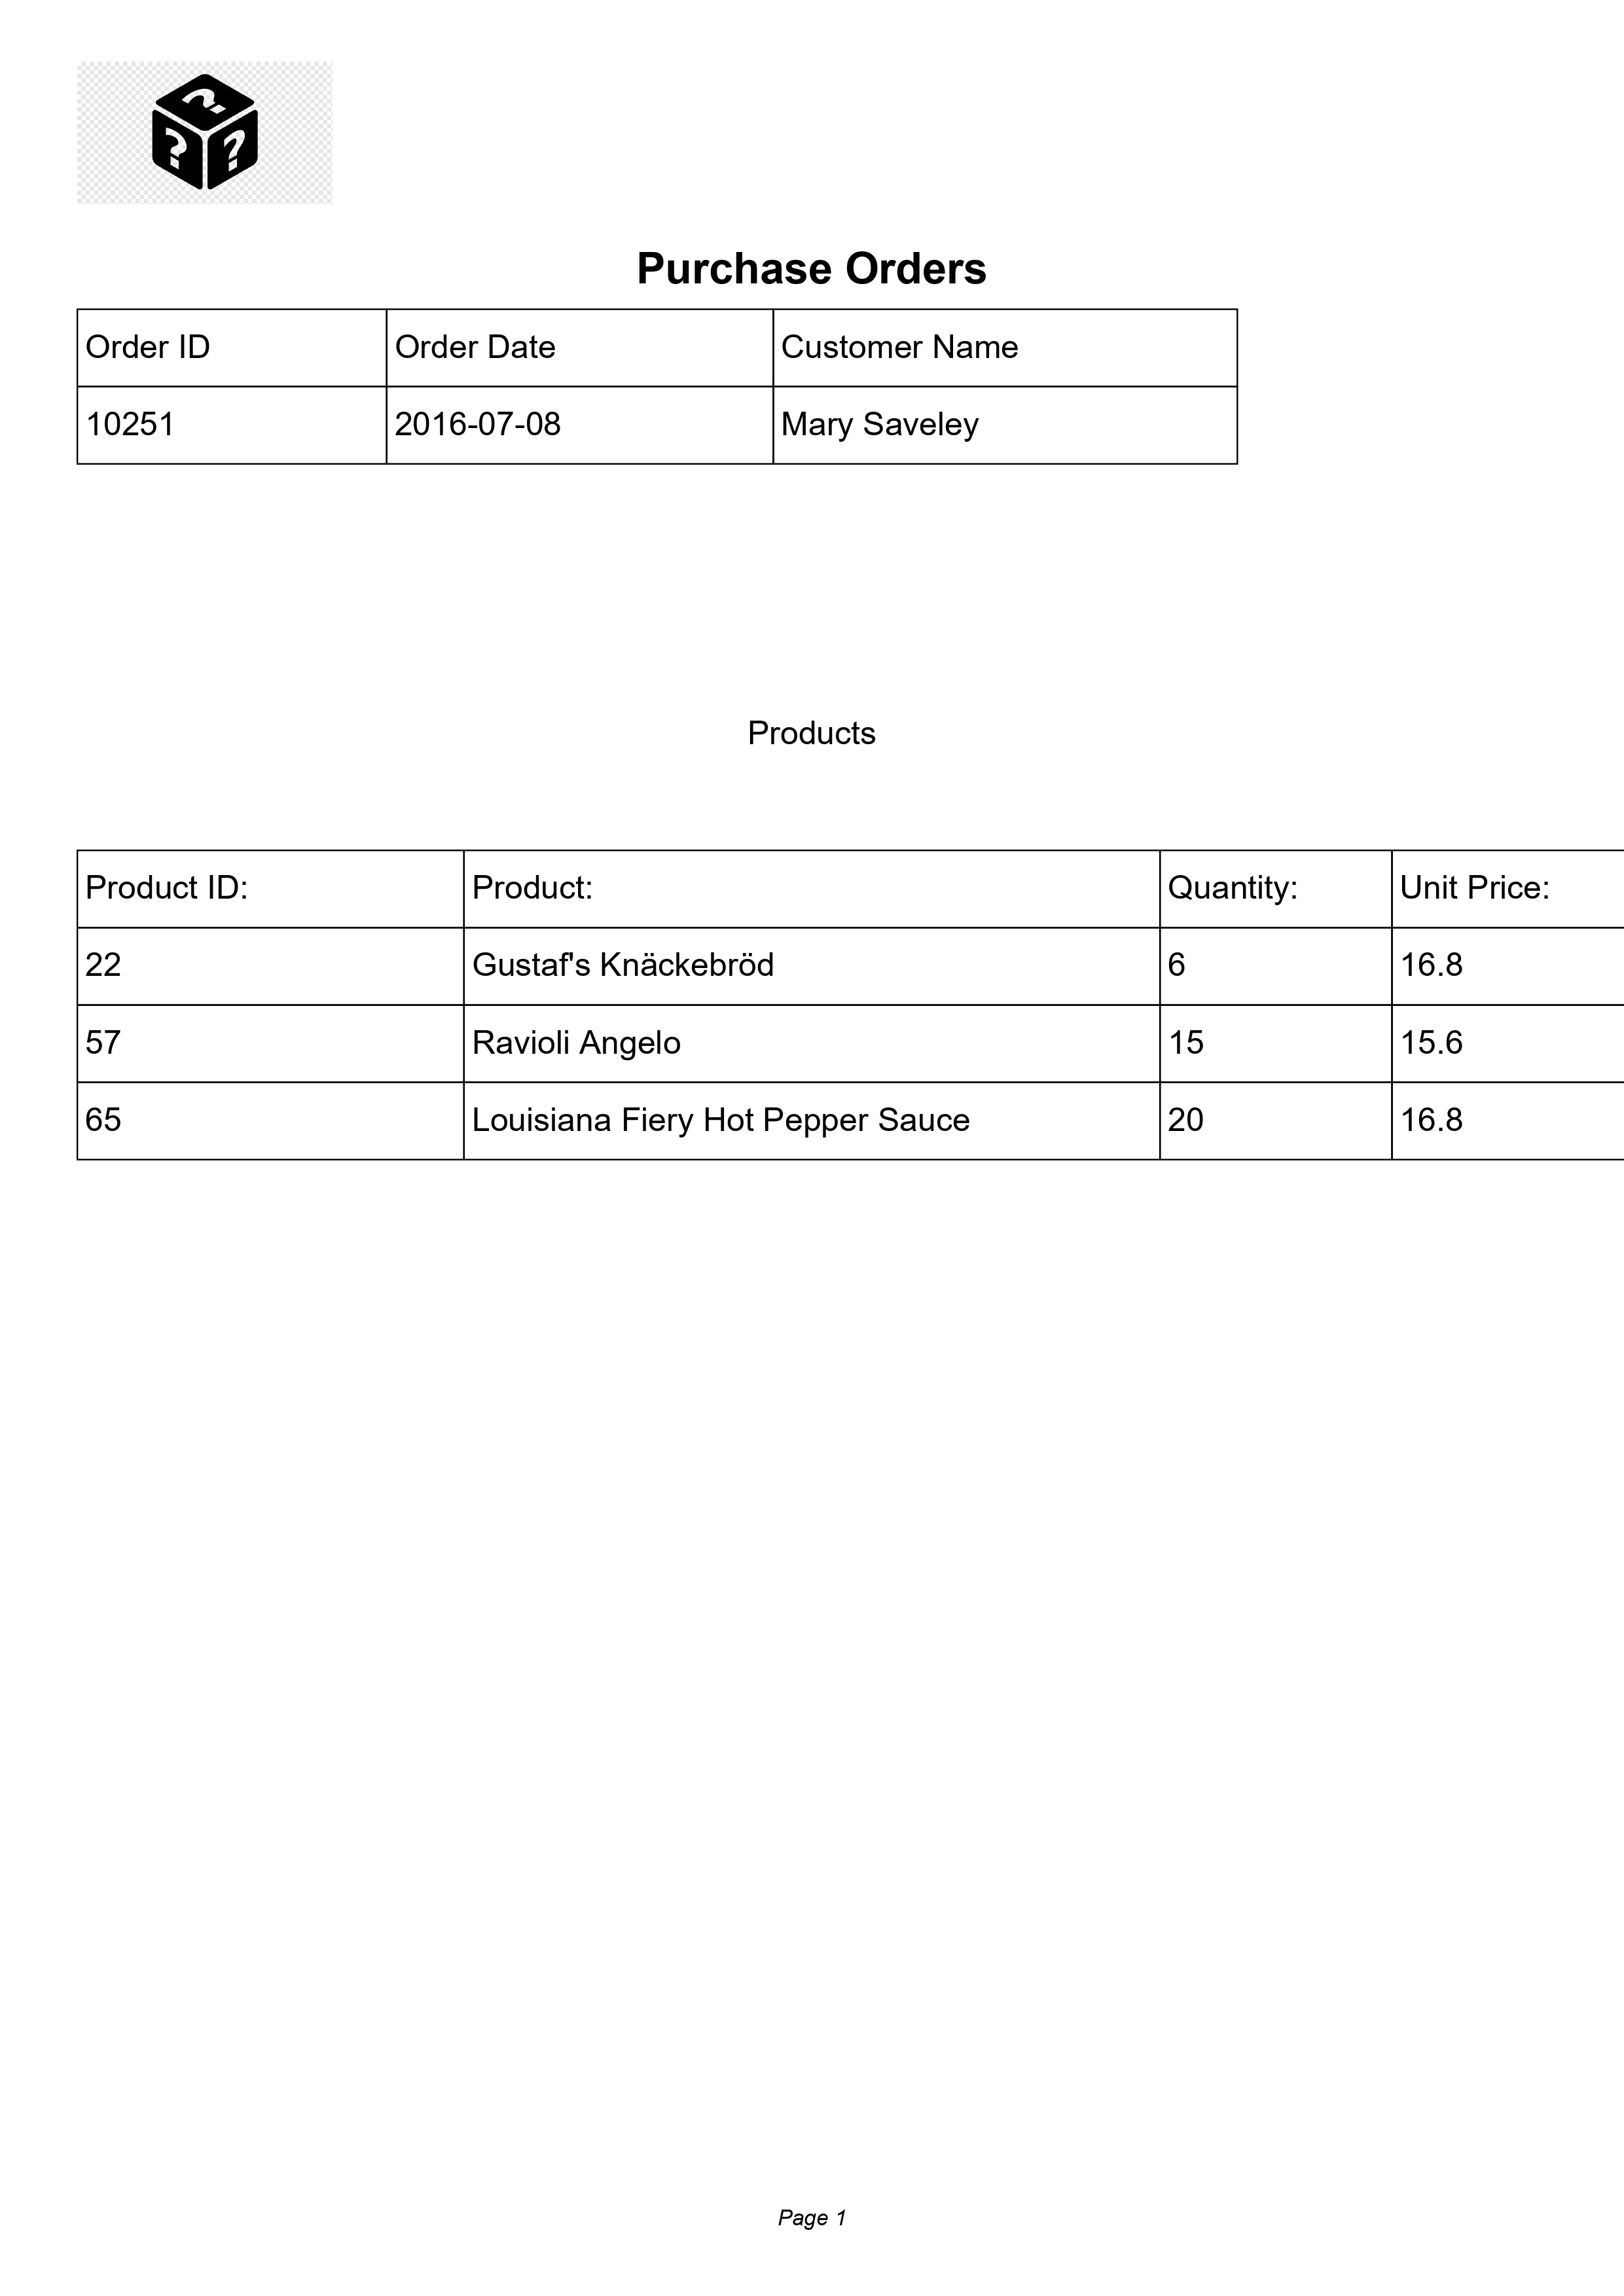

In [4]:
example = dataset["train"][0]
example["image"]

### Training

In [5]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [6]:
import numpy as np
from datasets.features import ClassLabel

return_entity_level_metrics = False

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

In [7]:
# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

In [8]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [9]:
# Tokenize the inputs
def prepare_examples(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    boxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]

    encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

    return encoding

In [10]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [11]:
if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [12]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

In [13]:
from datasets import load_metric

metric = load_metric("seqeval", trust_remote_code=True)

C:\Users\datacore\AppData\Local\Temp\ipykernel_9132\1255862948.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval", trust_remote_code=True)


In [14]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=10,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

d:\SKU\layoutenv\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [17]:
trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]d:\SKU\layoutenv\Lib\site-packages\transformers\modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 10/10 [01:52<00:00, 11.24s/it]

{'train_runtime': 112.3769, 'train_samples_per_second': 0.178, 'train_steps_per_second': 0.089, 'train_loss': 1.0027568817138672, 'epoch': 2.5}


TrainOutput(global_step=10, training_loss=1.0027568817138672, metrics={'train_runtime': 112.3769, 'train_samples_per_second': 0.178, 'train_steps_per_second': 0.089, 'total_flos': 4744726087680.0, 'train_loss': 1.0027568817138672, 'epoch': 2.5})

In [18]:
trainer.evaluate()

d:\SKU\layoutenv\Lib\site-packages\transformers\modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]d:\SKU\layoutenv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Order ID seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\SKU\layoutenv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Order Date seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\SKU\layoutenv\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Customer Name seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


{'eval_loss': 0.7103776335716248,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 10.3072,
 'eval_samples_per_second': 0.291,
 'eval_steps_per_second': 0.194,
 'epoch': 2.5}

In [19]:
from transformers import LayoutLMForTokenClassification, LayoutLMTokenizer

# Assuming your model is named 'model' and tokenizer is named 'tokenizer'

# Save configuration
model_path = "D:\\SKU\\results"
model.config.save_pretrained(model_path)

# Save model state_dict (weights)
model.save_pretrained(model_path)

### Testing

In [20]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("D:\\SKU\\test\\checkpoint-10")

In [21]:
example = dataset["test"][0]
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

print(example, image, words, boxes, word_labels)

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

{'id': '0', 'tokens': ['10249', '2016-07-05', 'Karin', 'Josephs'], 'bboxes': [[54, 179, 107, 189], [243, 179, 345, 189], [482, 179, 526, 189], [534, 179, 607, 192]], 'ner_tags': [0, 1, 2, 2], 'image_path': './layoutlmv3\\55ccaed1-purchase_orders_10249-page-00001.jpg', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2481x3508 at 0x21F56280A50>} <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2481x3508 at 0x21F56280A50> ['10249', '2016-07-05', 'Karin', 'Josephs'] [[54, 179, 107, 189], [243, 179, 345, 189], [482, 179, 526, 189], [534, 179, 607, 192]] [0, 1, 2, 2]
input_ids torch.Size([1, 12])
attention_mask torch.Size([1, 12])
bbox torch.Size([1, 12, 4])
labels torch.Size([1, 12])
pixel_values torch.Size([1, 3, 224, 224])


In [22]:
import torch
with torch.no_grad():
    outputs = model(**encoding)

logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

Order ID
Order Date
Customer Name
Customer Name


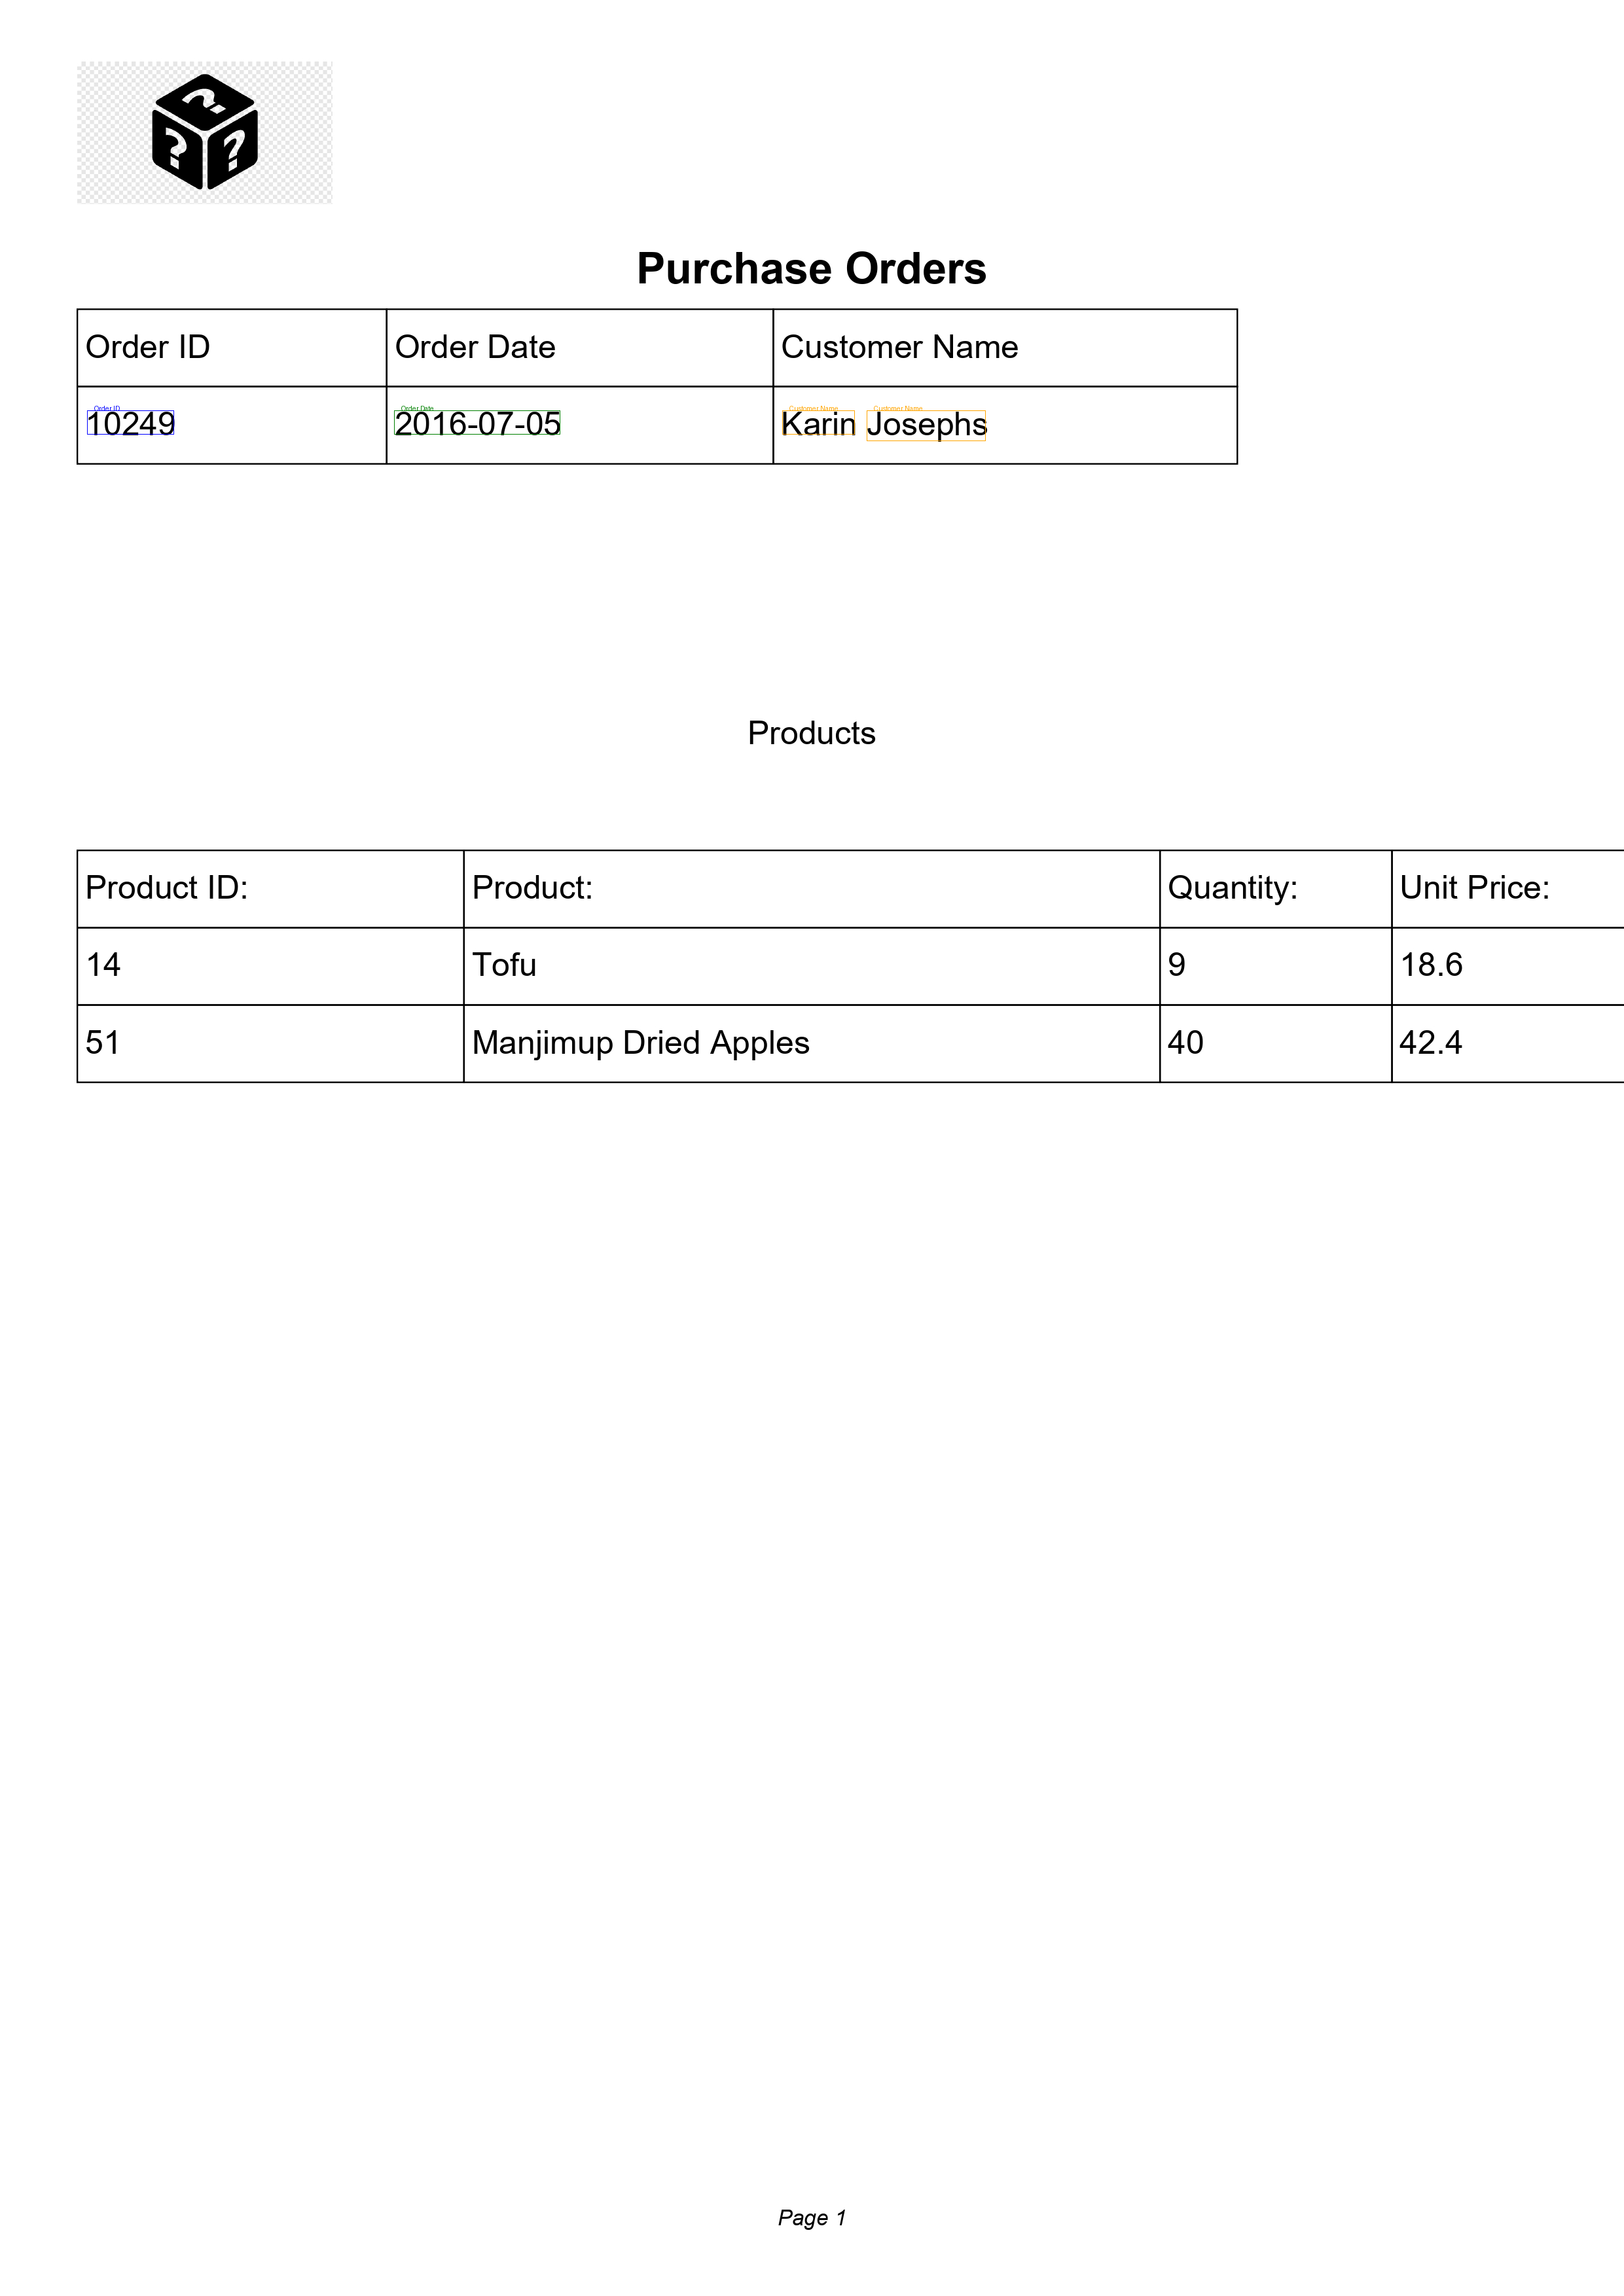

In [23]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label
    if not label:
      return 'other'
    return label

label2color = {'Order ID':'blue', 'Order Date':'green', 'Customer Name':'orange'}

for prediction, box in zip(true_predictions, true_boxes):
    print(prediction)
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image